In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Additional Info when using cuda
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")

# To watch nvidia-smi continuously after every 2 seconds: watch -n 2 nvidia-smi

Using device: cuda
Quadro M5000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
BATCH_SIZE = 20
EPOCHS = 20

In [ ]:
from common.data_pipeline.MMCBNU_6000.dataset import DatasetLoader as mmcbnu
from common.data_pipeline.FV_USM.dataset import DatasetLoader as fvusm
from common.util.data_pipeline.dataset_chainer import DatasetChainer
from common.util.enums import EnvironmentType

environment = EnvironmentType.PYTORCH
datasets = DatasetChainer(
    datasets=[
        mmcbnu(included_portion=1, environment_type=environment),
        fvusm(included_portion=0, environment_type=environment),
    ]
)
train, test, validation = datasets.get_dataset(environment, batch_size=BATCH_SIZE)

2023-09-12 21:30:19,765 - root - INFO - Preprocessing MMCBNU6000 dataset for train split.
100%|██████████| 4800/4800 [00:01<00:00, 3281.61it/s]
2023-09-12 21:30:21,568 - root - INFO - Preprocessing MMCBNU6000 dataset for test split.
0it [00:00, ?it/s]
2023-09-12 21:30:21,568 - root - INFO - Preprocessing MMCBNU6000 dataset for validation split.
100%|██████████| 1200/1200 [00:00<00:00, 3305.99it/s]
2023-09-12 21:30:22,061 - root - INFO - Preprocessing FV_USM dataset for train split.
0it [00:00, ?it/s]
2023-09-12 21:30:22,063 - root - INFO - Preprocessing FV_USM dataset for test split.
0it [00:00, ?it/s]
2023-09-12 21:30:22,063 - root - INFO - Preprocessing FV_USM dataset for validation split.
0it [00:00, ?it/s]
2023-09-12 21:30:22,063 - root - INFO - Concatenating train set
2023-09-12 21:30:22,341 - root - INFO - Concatenating test set
2023-09-12 21:30:22,341 - root - INFO - Concatenating validation set


In [ ]:
image, labels = train.dataset.data
print(image.shape, labels.shape)

(4800, 3, 60, 120) (4800, 100)


In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
import torch

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
torch.save(model, "models/resnet50_pretrained.pt")

In [ ]:
model = torch.load(f"models/resnet50_pretrained.pt").to(device)

In [ ]:
from common.train_pipeline.model.isotropic_vig import isotropic_vig_ti_224_gelu

model = isotropic_vig_ti_224_gelu()
model.to(device)
print()
# print(model)

c:\ProgramData\anaconda3\envs\dl-torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dpr [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
num_knn [9, 9, 10, 11, 12, 13, 13, 14, 15, 16, 17, 18]



In [ ]:
with torch.no_grad():
    for inputs, labels in train:
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        print(inputs.shape)
        x = model.conv1(inputs)
        print(x.shape)
        x = model.bn1(x)
        print(x.shape)
        x = model.relu(x)
        print(x.shape)
        x = model.maxpool(x)
        print(x.shape)
        x = model.layer1(x)
        print(x.shape)
        x = model.layer2(x)
        print(x.shape)
        x = model.layer3(x)
        print(x.shape)
        x = model.layer4(x)
        print(x.shape)
        break

torch.Size([20, 3, 60, 120])
torch.Size([20, 64, 30, 60])
torch.Size([20, 64, 30, 60])
torch.Size([20, 64, 30, 60])
torch.Size([20, 64, 15, 30])
torch.Size([20, 256, 15, 30])
torch.Size([20, 512, 8, 15])
torch.Size([20, 1024, 4, 8])
torch.Size([20, 2048, 2, 4])


In [ ]:
import torch.optim as optim
import torch.nn as nn
import torch
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=0.001)
jsd = None
mixup_active = None

train_loss_fn = nn.CrossEntropyLoss().cuda()
validate_loss_fn = nn.CrossEntropyLoss().cuda()

# Training loop
for epoch in range(EPOCHS):
    # model.train()
    with torch.no_grad():
        for inputs, labels in tqdm(train, desc=f"Epoch {epoch}: "):
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = train_loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation:
            inputs = inputs.float().to(device)
            labels = labels.float().to(device)
            outputs = model(inputs)
            val_loss += validate_loss_fn(outputs, labels)
            predicted = (outputs == outputs.max()).float()
            total += labels.size(0)

            correct += (predicted & labels).sum().item()

    print(
        f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Accuracy: {(correct/total)*100:.2f}%"
    )
model.train()

Epoch 0:   0%|          | 0/240 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/240 [00:03<?, ?it/s]


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

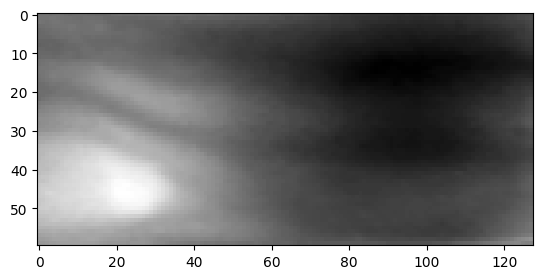

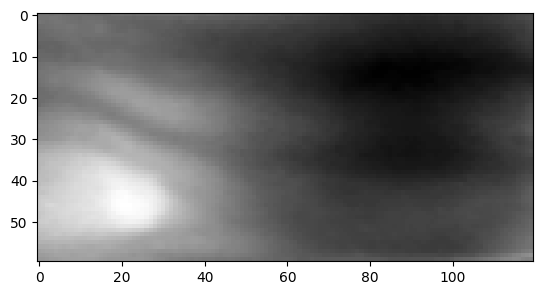

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

image_path = "./datasets/MMCBNU_6000/ROIs/084/L_Fore/02.bmp"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap="gray")
plt.show()
res_img = cv2.resize(image, (120, 60))
plt.imshow(res_img, cmap="gray")
plt.show()

(60, 128, 3)


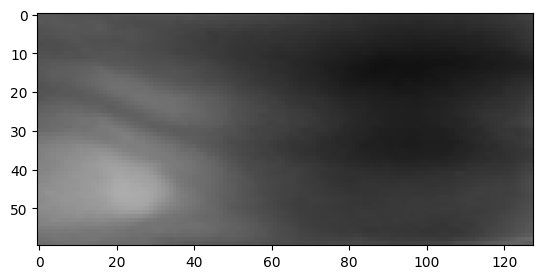

In [ ]:
image_rgb = np.stack([image, image, image], axis=2)
print(image_rgb.shape)
plt.imshow(image_rgb)

In [1]:
from common.train_pipeline.backbone.backbone import get_backbone
from common.train_pipeline.config import ModelConfiguration

config = ModelConfiguration()
print(get_backbone(config))

/home/a-150/anaconda3/envs/dl-torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'ModelConfiguration' from 'common.train_pipeline.config' (unknown location)